<a href="https://colab.research.google.com/github/kevinhoffmanglyde/oxfordgenaigroup2/blob/main/Group2EndtoEnd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Section Overview:#
This section is a model comparision for selection of the models.
To use the selected model in the project for the business, we need to be able to feed in a full dataset, retrain the model based on the new data, and create predictions based on the fresh data and newly trained model.
This section separates the Training and Test data for checking accuracy and loss in order to select the better model for the job.
###2024-05-06 - there are some issues with the presentation of charts for comparison.  Also, Prophet is working but requires different names for comparison.  The predictions across the board look like a near perfect match to the Test data.  This is unexpected.  The visualisations are currently wholey unsatisfactory.###


#Mount the Google Drive

In [31]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Authenticate

In [32]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


#Get the data

In [33]:
df = pd.read_csv('gdrive/MyDrive/synt_data_500k.csv')

#Check the data is there

In [34]:
df.head()

,Store ID,Country,Product ID,Product Category,Units Sold,Date of Sale,GDP Growth Rate,Inflation Rate,Price Sold
0,6076,Netherlands,33769,Womens,57,2024-04-05,3.8,0.1,56.25
1,2068,Germany,38979,Mens,54,2024-04-05,5.9,-0.5,40.26
2,8082,Sweden,91197,Womens,52,2024-04-05,4.4,-0.2,82.02
3,8077,Sweden,73096,Womens,66,2024-04-05,4.4,-0.2,29.50
4,10066,Denmark,26302,Mens,24,2024-04-05,4.3,1.9,34.41


##Now examine the data
The biggest worry is that once we get to the testing of the model, using the synthetic data, we may be trying to map the model based on the training data to data that is completely random.
Since we have data for May 2023 to May 2024 I selected a splitting date of Feb 1st 2024 so we have nearly a 75 to 25% split and are predicting for the latter quarter of the timeframe.
I did not split on the random 80/20 split because we would be including values for the prediction timeframe in the Training set, if I did.

In [35]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import datetime
datetosplit = '2024-02-01'
reference_date = datetime.date(1970, 1, 1)
# train_test_split is used to easily divide data into training and testing sets.
from sklearn.model_selection import train_test_split
# LinearRegression is the model we'll be using from scikit-learn.
from sklearn.linear_model import LinearRegression
# mean_absolute_error and mean_squared_error are metrics to evaluate our model.
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# matplotlib.pyplot is used for plotting graphs.
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [36]:
df = df.sort_values(["Date of Sale"], ascending = (True)) # order the data by year, month, day in ascending order.
df.head() # check the data again by viewing the first 5 rows

,Store ID,Country,Product ID,Product Category,Units Sold,Date of Sale,GDP Growth Rate,Inflation Rate,Price Sold
499999,5008,Spain,73099,Womens,14,2023-05-06,8.4,8.4,90.98
498988,4075,Italy,23652,Mens,45,2023-05-06,8.2,8.2,66.88
498989,8029,Sweden,73547,Mens,43,2023-05-06,8.4,8.4,74.31
498990,8070,Sweden,31522,Mens,35,2023-05-06,8.4,8.4,28.41
498991,7007,Belgium,71398,Womens,7,2023-05-06,9.6,9.6,16.95


In [37]:
df.describe()

,Store ID,Product ID,Units Sold,GDP Growth Rate,Inflation Rate,Price Sold
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,5553.060138,55033.952428,50.465604,7.593749,6.331376,55.016995
std,2871.224980,25968.573197,28.828142,2.036724,3.799314,26.013740
min,1000.000000,10000.000000,1.000000,3.800000,-0.800000,10.000000
25%,3050.000000,32562.000000,26.000000,5.900000,1.900000,32.480000
50%,6000.000000,55064.000000,50.000000,7.900000,7.900000,55.030000
75%,8050.000000,77531.000000,75.000000,8.600000,8.600000,77.560000
max,10100.000000,99999.000000,100.000000,11.100000,11.100000,100.000000


In [38]:
df.isnull().sum()

Store ID            0
Country             0
Product ID          0
Product Category    0
Units Sold          0
Date of Sale        0
GDP Growth Rate     0
Inflation Rate      0
Price Sold          0
dtype: int64

Looks like no Nulls, which is expected for our synthetic data.

In [39]:
df['Units Sold'].isna().sum()

0

In [40]:
#clean up any nulls that might come through in real data
df = df.dropna(subset=['Store ID', 'Product ID', 'Units Sold', 'Date of Sale'])

##Check out the distribution of the data

In [41]:
unique_store = df['Store ID'].nunique()
unique_product = df['Product ID'].nunique()
unique_product_cat = df['Product Category'].nunique()
unique_country = df['Country'].nunique()


print("Distinct Stores:", unique_store)
print("Distinct Products:", unique_product)
print("Distinct Product Categories:", unique_product_cat)
print("Distinct Countries:", unique_country)

Distinct Stores: 1010
Distinct Products: 89653
Distinct Product Categories: 2
Distinct Countries: 10


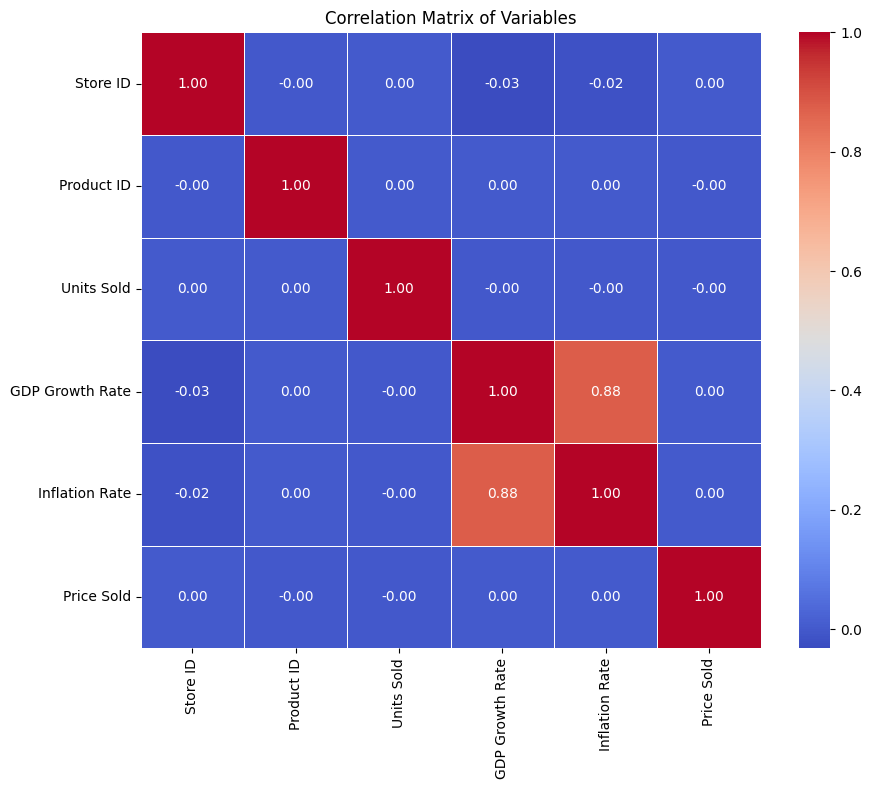

In [42]:
# Calculating the correlation matrix
correlation_matrix = df.corr(numeric_only=True)
#numeric_only is a new variable for the correlation matrix.
#If we want to include Country, we would have to include one-hot-encoding on Country because it is a string and will not fit in a correlation matrix.
# Initializes a new figure for plotting with a specified size to ensure the heatmap is large enough to read.
plt.figure(figsize=(10, 8))

# Creates a heatmap to visualize the correlation matrix.
# - annot=True displays the correlation coefficient values inside the squares.
# - cmap='coolwarm' chooses a color map that visually represents positive (warm) and negative (cool) correlations.
# - fmt=".2f" formats the annotation strings to display only two decimal places.
# - linewidths=.5 adds lines between squares to separate them visually.
sn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Sets the title of the heatmap for clarity.
plt.title('Correlation Matrix of Variables')

# Displays the plot. Without this, the figure would not be shown in a notebook.
plt.show()

In [43]:
min_sale_date = df['Date of Sale'].min()
max_sale_date = df['Date of Sale'].max()

print("Minimum date:", min_sale_date)
print("Maximum date:", max_sale_date)

Minimum date: 2023-05-06
Maximum date: 2024-04-05


#Date issues##
Since we are trying to predict future demand, this suggests that when we divide the Training and Test data, we need to do this on a date basis.  Including dates in the training set that should appear in the test set is not desired.  When using this on real data in production, the future dates will all be empty.

So, selecting out test and train data set should probably be on dates rather than simply a percentage.  The suggestion here is that we train 9 months and test against 3 months.

Once the data split is completed, I had to drop the Date of Sale feature because it would not process as a number.  The componensts of the date can be reconstituted for charts at a later point.
The below includes one-hot encoding for the Product Category and Country.

In [44]:
df['Date of Sale'] = pd.to_datetime(df['Date of Sale'])
print(df['Date of Sale'].head(10))
#df['Units Sold'] = df['Units Sold'].astype(int)
print('Actuals:', df['Units Sold'].head(10))

# find the rows that contain non-integer values
print(df['Units Sold'].head(10))

499999   2023-05-06
498988   2023-05-06
498989   2023-05-06
498990   2023-05-06
498991   2023-05-06
498992   2023-05-06
498993   2023-05-06
498994   2023-05-06
498995   2023-05-06
498996   2023-05-06
Name: Date of Sale, dtype: datetime64[ns]
Actuals: 499999    14
498988    45
498989    43
498990    35
498991     7
498992    20
498993    74
498994    81
498995    81
498996    75
Name: Units Sold, dtype: int64
499999    14
498988    45
498989    43
498990    35
498991     7
498992    20
498993    74
498994    81
498995    81
498996    75
Name: Units Sold, dtype: int64


#Split the data into Past and "Future"

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

df['Date of Sale'] = pd.to_datetime(df['Date of Sale'])
#df['DOS'] = (df['Date of Sale'] - reference_date).days
# Selecting the features for the model. These are the independent variables.
#X = df[['Store ID', 'Product Category', 'Date of Sale', 	'GDP Growth Rate',	'Inflation Rate',	'Price Sold']]

# Data Scaling

X = df[['Store ID', 'Date of Sale', 'GDP Growth Rate', 'Inflation Rate', 'Price Sold']]
X = pd.get_dummies(df, columns=['Product Category'])
X = pd.get_dummies(X, columns=['Country'])
X['Year'] = df['Date of Sale'].dt.year
X['Month'] = df['Date of Sale'].dt.month
X['Day'] = df['Date of Sale'].dt.day
X['Weekday'] = df['Date of Sale'].dt.weekday  # Monday=0, Sunday=6

y = df['Units Sold']
split_date = pd.to_datetime(datetosplit)
# Data before the split date
X_Train = X[X['Date of Sale'] < split_date]
X_Test = X[X['Date of Sale'] >= split_date]
Y_Train = y[df['Date of Sale'] < split_date]
Y_Test = y[df['Date of Sale'] >= split_date]
X_Train = X_Train.drop(columns=['Date of Sale'])

X_Test = X_Test.drop(columns=['Date of Sale'])
#scaler = StandardScaler()
#X_Train = scaler.fit_transform(X_Train)
#X_Test = scaler.fit_transform(X_Test)
print("Data before the split date:")
print(X_Train)

print("Data on or after the split date:")
print(X_Test)

print("Data before the split date:")
print(Y_Train)

print("Data on or after the split date:")
print(Y_Test)

Data before the split date:
        Store ID  Product ID  Units Sold  GDP Growth Rate  Inflation Rate  \
499999      5008       73099          14              8.4             8.4   
498988      4075       23652          45              8.2             8.2   
498989      8029       73547          43              8.4             8.4   
498990      8070       31522          35              8.4             8.4   
498991      7007       71398           7              9.6             9.6   
...          ...         ...         ...              ...             ...   
97502       9045       54618          60              7.7            -0.8   
97503       7097       92686          35              5.3             1.5   
97504       6065       93805          47              3.8             0.1   
97496       1064       59665          72              3.8             0.1   
97487       1066       18171          21              3.8             0.1   

        Price Sold  Product Category_Mens  Prod

#Linear Regression model

In [46]:
# Creating an instance of the LinearRegression model.
modelLR = LinearRegression()

# Fitting the model to the training data. This is where the model learns the relationship between features and target.
modelLR.fit(X_Train, Y_Train)


LinearRegression()

In [47]:
# Cross-validating the model
scores = cross_val_score(modelLR, X_Train, Y_Train, cv=5)
print(f"Cross-validated R² scores: {scores}")
print(f"Average R² score: {np.mean(scores)}")

Cross-validated R² scores: [1. 1. 1. 1. 1.]
Average R² score: 1.0


In [48]:
# Use the trained model to make predictions on the testing set.
predictionsLR = modelLR.predict(X_Test)

# Evaluating the model's performance by comparing actual values (y_test) vs predicted values (predictions).
# MAE is the mean absolute error, MSE is the mean squared error, and RMSE is the square root of MSE.

# Evaluating the model
mse = mean_squared_error(Y_Test, predictionsLR)
r2 = r2_score(Y_Test, predictionsLR)
print('MAE:', mean_absolute_error(Y_Test, predictionsLR))
print('MSE:', mean_squared_error(Y_Test, predictionsLR))
print('RMSE:', np.sqrt(mean_squared_error(Y_Test, predictionsLR)))
print(f"R² score: {r2}")

MAE: 1.1075961710984388e-13
MSE: 1.790724975667942e-26
RMSE: 1.3381797247260706e-13
R² score: 1.0


In [49]:
X.describe()

,Store ID,Product ID,Units Sold,Date of Sale,GDP Growth Rate,Inflation Rate,Price Sold,Year,Month,Day,Weekday
count,500000.000000,500000.000000,500000.000000,500000,500000.000000,500000.000000,500000.000000,500000.00000,500000.000000,500000.000000,500000.000000
mean,5553.060138,55033.952428,50.465604,2023-10-20 14:50:45.484799744,7.593749,6.331376,55.016995,2023.28598,6.724422,15.762502,2.999062
min,1000.000000,10000.000000,1.000000,2023-05-06 00:00:00,3.800000,-0.800000,10.000000,2023.00000,1.000000,1.000000,0.000000
25%,3050.000000,32562.000000,26.000000,2023-07-29 00:00:00,5.900000,1.900000,32.480000,2023.00000,3.000000,8.000000,1.000000
50%,6000.000000,55064.000000,50.000000,2023-10-21 00:00:00,7.900000,7.900000,55.030000,2023.00000,7.000000,16.000000,3.000000
75%,8050.000000,77531.000000,75.000000,2024-01-13 00:00:00,8.600000,8.600000,77.560000,2024.00000,10.000000,23.000000,5.000000
max,10100.000000,99999.000000,100.000000,2024-04-05 00:00:00,11.100000,11.100000,100.000000,2024.00000,12.000000,31.000000,6.000000
std,2871.224980,25968.573197,28.828142,NaN,2.036724,3.799314,26.013740,0.45188,3.528619,8.821528,1.998637


#Charts#
I'm fairly sure I made an error somewhwere in here because it seems that the predicted values and actual values are the same according to the chart.  According the the MAE this is not the case.
I printed out the values for prediction and test, and the results were a match for what values I could see.

       Store ID  Product ID  Units Sold  GDP Growth Rate  Inflation Rate  \
95528      4095       89267          99              5.7             0.9   
95530      9055       37189          76              7.7            -0.8   
95529      3002       58600          15              5.7             0.9   
95542      1061       67217           4              3.8             0.1   
95526      1024       20806          45              3.8             0.1   
...         ...         ...         ...              ...             ...   
1018       6013       87054          51              3.8             0.1   
1019       6069       18184          90              3.8             0.1   
1020       1100       92598          61              3.8             0.1   
1011       6040       94885          23              3.8             0.1   
0          6076       33769          57              3.8             0.1   

       Price Sold  Product Category_Mens  Product Category_Womens  \
95528       26.47 

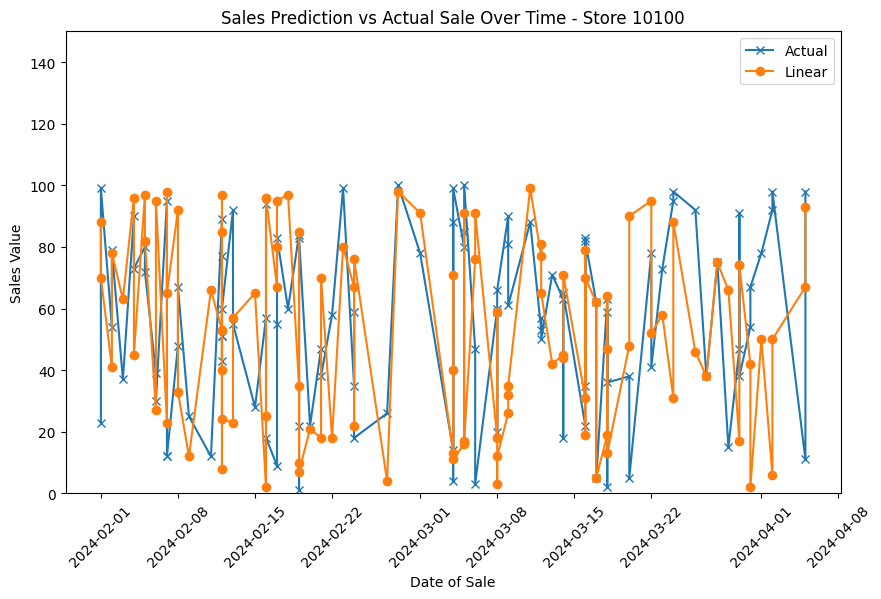

In [50]:
from datetime import datetime

print( X_Test)
X_Test['Date of Sale'] = pd.to_datetime(X_Test[['Year', 'Month', 'Day']])


merged_df = pd.merge(X_Test, Y_Test, left_index=True, right_index=True)
filtered_df = merged_df[merged_df['Store ID'] == 10100]
df_1d = pd.DataFrame(predictionsLR, columns=['Prediction'])
merged_df2 = pd.merge(X_Test, df_1d, left_index=True, right_index=True)
filtered_df2 = merged_df2[merged_df2['Store ID'] == 10100]
#print(filtered_df2)
plt.figure(figsize=(10, 6))  # Set the figure size= modelLR.predict(X_Test)
#print(filtered_df)
plt.plot(filtered_df['Date of Sale'] , filtered_df['Units Sold_y'], label='Actual', marker='x')  # Plot Sales Prediction
plt.plot(filtered_df2['Date of Sale'] ,  filtered_df2['Prediction'], label='Linear', marker='o')  # Plot Sales Prediction
# Adding titles and labels
plt.title('Sales Prediction vs Actual Sale Over Time - Store 10100')
plt.xlabel('Date of Sale')
plt.ylabel('Sales Value')
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.ylim(0, 150)

# Adding legend
plt.legend()

# Show the plot
plt.show()
X_Test = X_Test.drop(columns=['Date of Sale'])

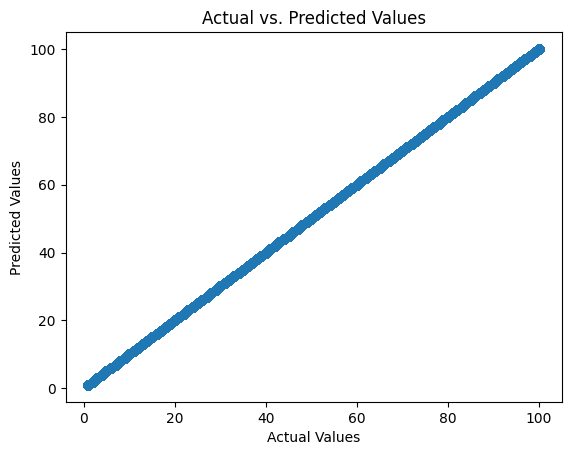

In [51]:
# Plotting actual vs predicted values to visualize how well our model is performing.
plt.scatter(Y_Test, predictionsLR)
plt.xlabel('Actual Values')  # X-axis label
plt.ylabel('Predicted Values')  # Y-axis label
plt.title('Actual vs. Predicted Values')  # Graph title
plt.show()  # Display the plot

#Random Forest

In [ ]:
# Creating an instance of the LinearRegression model.
modelRF = RandomForestRegressor()

# Fitting the model to the training data. This is where the model learns the relationship between features and target.
modelRF.fit(X_Train, Y_Train)

RandomForestRegressor()

In [ ]:
# Use the trained model to make predictions on the testing set.
predictionsRF = modelRF.predict(X_Test)

# Evaluating the model's performance by comparing actual values (y_test) vs predicted values (predictions).
# MAE is the mean absolute error, MSE is the mean squared error, and RMSE is the square root of MSE.
print('MAE:', mean_absolute_error(Y_Test, predictionsRF))
print('MSE:', mean_squared_error(Y_Test, predictionsRF))
print('RMSE:', np.sqrt(mean_squared_error(Y_Test, predictionsRF)))

MAE: 0.0
MSE: 0.0
RMSE: 0.0


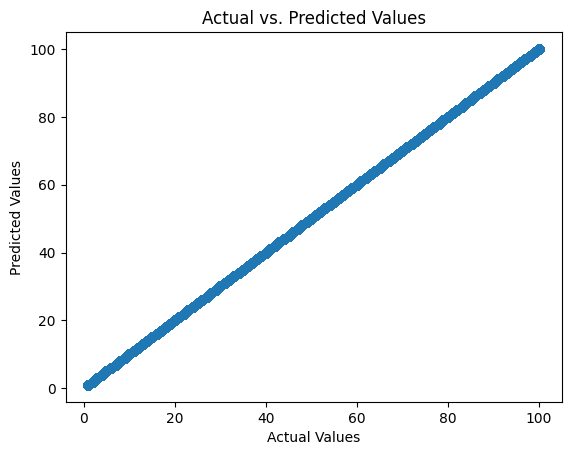

In [ ]:
# Plotting actual vs predicted values to visualize how well our model is performing.
plt.scatter(Y_Test, predictionsRF)
plt.xlabel('Actual Values')  # X-axis label
plt.ylabel('Predicted Values')  # Y-axis label
plt.title('Actual vs. Predicted Values')  # Graph title
plt.show()  # Display the plot

#Prophet

In [ ]:
pip install pystan


In [ ]:
#pip install fbprophet


In [ ]:
#pip install --upgrade numpy pandas

In [ ]:
pip install prophet


In [ ]:
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [ ]:
#this has all of the records without the split
dfpt = df
dfpt.rename(columns={'Date of Sale': 'ds', 'Units Sold': 'y'}, inplace=True)
dftrain = dfpt[dfpt['ds'] < split_date]
dftest = dfpt[dfpt['ds'] >= split_date]
modelPT = Prophet(yearly_seasonality=True)
modelPT.fit(dftrain)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmoavsl9r/hnc_gij8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmoavsl9r/7f09m2e4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29396', 'data', 'file=/tmp/tmpmoavsl9r/hnc_gij8.json', 'init=/tmp/tmpmoavsl9r/7f09m2e4.json', 'output', 'file=/tmp/tmpmoavsl9r/prophet_modelznjxfcdk/prophet_model-20240507132249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
#need to do the split on this to get the future
#future = modelPT.make_future_dataframe(periods=len(dftest), freq='D')
#forecast = modelPT.predict(future)

OutOfBoundsDatetime: Cannot generate range with start=1706659200000000000 and periods=96540

In [ ]:
#Not sure how valid this is for for Prophet
#print('MAE:', mean_absolute_error(Y_Test, forecast))
#print('MSE:', mean_squared_error(Y_Test, forecast))
#print('RMSE:', np.sqrt(mean_squared_error(Y_Test, forecast)))

In [ ]:
# Plotting actual vs predicted values to visualize how well our model is performing.
#plt.scatter(future['ds'], forecast)
#plt.xlabel('Actual Values')  # X-axis label
#plt.ylabel('Predicted Values')  # Y-axis label
#plt.title('Actual vs. Predicted Values')  # Graph title
#plt.show()  # Display the plot

#Gradient Booster

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
modelGB = GradientBoostingRegressor(random_state=42)
modelGB.fit(X_Train, Y_Train)

GradientBoostingRegressor(random_state=42)

In [ ]:
# Predictions
predGB = modelGB.predict(X_Test)

In [ ]:
# Evaluation
mae = mean_absolute_error(Y_Test, predGB)
mse = mean_squared_error(Y_Test, predGB)
r2 = r2_score(Y_Test, predGB)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Mean Absolute Error: 0.03352079894303137
Mean Squared Error: 0.002276445431460258
R² Score: 0.9999972546846675


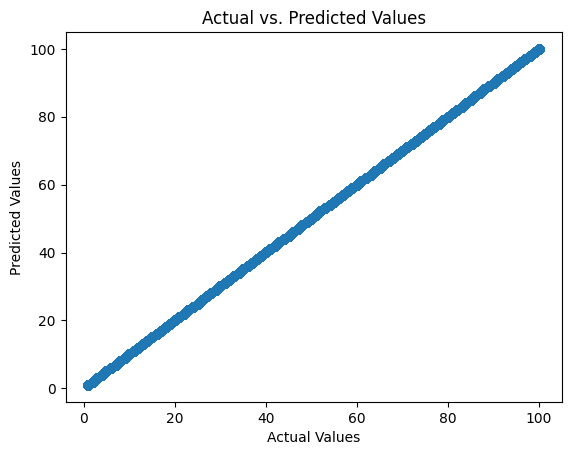

In [ ]:
# Plotting actual vs predicted values to visualize how well our model is performing.
plt.scatter(Y_Test, predGB)
plt.xlabel('Actual Values')  # X-axis label
plt.ylabel('Predicted Values')  # Y-axis label
plt.title('Actual vs. Predicted Values')  # Graph title
plt.show()  # Display the plot

#Long Term Short Memory

In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [ ]:
# Normalize features
scaler = MinMaxScaler()
target = X_Train['Units Sold'].values.reshape(-1,1)
features_scaled = scaler.fit_transform(X_Train)
target_scaled = scaler.fit_transform(target)

In [ ]:
# Data preparation for LSTM
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 1
X, y = create_dataset(features_scaled, target_scaled, time_steps)

In [ ]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Problem here is the fact that dates from the forecast period are likely to be in the Training data
#may be able to use the X_Train and X_Test values instead

In [ ]:
# LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Fit model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/30
10087/10087 [==============================] - 36s 3ms/step - loss: 0.0858 - val_loss: 0.0852
Epoch 2/30
10087/10087 [==============================] - 34s 3ms/step - loss: 0.0852 - val_loss: 0.0849
Epoch 3/30
10087/10087 [==============================] - 34s 3ms/step - loss: 0.0851 - val_loss: 0.0847
Epoch 4/30
10087/10087 [==============================] - 36s 4ms/step - loss: 0.0850 - val_loss: 0.0849
Epoch 5/30
10087/10087 [==============================] - 33s 3ms/step - loss: 0.0849 - val_loss: 0.0847
Epoch 6/30
10087/10087 [==============================] - 32s 3ms/step - loss: 0.0849 - val_loss: 0.0847
Epoch 7/30
10087/10087 [==============================] - 34s 3ms/step - loss: 0.0849 - val_loss: 0.0847
Epoch 8/30
10087/10087 [==============================] - 35s 3ms/step - loss: 0.0849 - val_loss: 0.0847
Epoch 9/30
10087/10087 [==============================] - 33s 3ms/step - loss: 0.0849 - val_loss: 0.0847
Epoch 10/30
10087/10087 [==============================

In [ ]:
# Predict and evaluate
predictionLSTM = model.predict(X_test)
mse = mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(predictionLSTM))
print(f'Mean Squared Error: {mse}')

2522/2522 [==============================] - 4s 2ms/step
Mean Squared Error: 830.6033535861192


In [ ]:
print(Y_Test)
print()
print(predictionLSTM)

95528    99
95530    76
95529    15
95542     4
95526    45
         ..
1018     51
1019     90
1020     61
1011     23
0        57
Name: Units Sold, Length: 96539, dtype: int64

[[0.49066138]
 [0.4950527 ]
 [0.504165  ]
 ...
 [0.4924637 ]
 [0.49306798]
 [0.49051353]]


95528   2024-02-01
95530   2024-02-01
95529   2024-02-01
95542   2024-02-01
95526   2024-02-01
95525   2024-02-01
95524   2024-02-01
95523   2024-02-01
95527   2024-02-01
95531   2024-02-01
Name: Date of Sale, dtype: datetime64[ns]


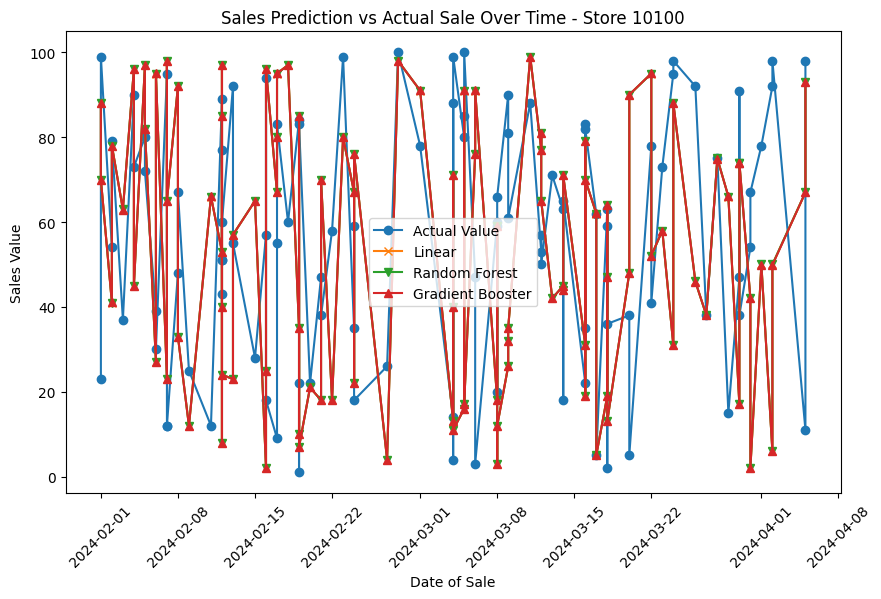

In [ ]:
# Create the plot
from datetime import datetime
X_Test['Date of Sale'] = pd.to_datetime(X_Test[['Year', 'Month', 'Day']])
print(X_Test['Date of Sale'].head(10))

merged_df = pd.merge(X_Test, Y_Test, left_index=True, right_index=True)
filtered_df = merged_df[merged_df['Store ID'] == 10100]
df_1d = pd.DataFrame(predictionsLR, columns=['Prediction'])
df_1d2 = pd.DataFrame(predictionsRF, columns=['PredictionRF'])
df_1d3 = pd.DataFrame(predGB, columns=['PredictionGB'])
merged_df2 = pd.merge(X_Test, df_1d, left_index=True, right_index=True)
filtered_df2 = merged_df2[merged_df2['Store ID'] == 10100]
merged_df3 = pd.merge(X_Test, df_1d2, left_index=True, right_index=True)
filtered_df3 = merged_df3[merged_df3['Store ID'] == 10100]
merged_df4 = pd.merge(X_Test, df_1d3, left_index=True, right_index=True)
filtered_df4 = merged_df4[merged_df4['Store ID'] == 10100]


#X_Test['Date of Sale'] = pd.to_datetime(str(X_Test['Year']) + '-' + str(X_Test['Month']) + '-' + str(X_Test['Day']))
plt.figure(figsize=(10, 6))  # Set the figure size= modelLR.predict(X_Test)
plt.plot(filtered_df['Date of Sale'] , filtered_df['Units Sold_y'], label='Actual Value', marker='o')  # Plot Sales Prediction
plt.plot(filtered_df2['Date of Sale'] , filtered_df2['Prediction'], label='Linear', marker='x')  # Plot Sales Prediction
plt.plot(filtered_df3['Date of Sale'] , filtered_df3['PredictionRF'], label='Random Forest', marker='v')  # Plot Sales Prediction
plt.plot(filtered_df4['Date of Sale'] , filtered_df4['PredictionGB'], label='Gradient Booster', marker='^')  # Plot Sales Prediction
#plt.plot(X_Test['Month'] , predictionLSTM, label='Long Term Short Memory', marker='x')  # Plot Sales Prediction

# Adding titles and labels
plt.title('Sales Prediction vs Actual Sale Over Time - Store 10100')
plt.xlabel('Date of Sale')
plt.ylabel('Sales Value')
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Adding legend
plt.legend()

# Show the plot
plt.show()


#Future Steps
For this to be used in the business:
We need to be able to feed in new data and train on that data.  That would be the new Training set.
We then calculate a forecast for the next time period based on the new Training set.